In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint

# As the dataset is divided into folders
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# load Data

In [2]:
w,h = 250,250
batch_size = 16

train_path = 'xray/train/'
test_path = 'xray/test/'
val_path = 'xray/val/'

train_img_gen = ImageDataGenerator(
    rescale = 1.0/255,
    zoom_range=0.3
    # preprocessing_function = exposure_contrast_setting
)

test_img_gen = ImageDataGenerator(
    rescale = 1.0/255,
    # preprocessing_function = exposure_contrast_setting
)

val_img_gen = ImageDataGenerator(
    rescale = 1.0/255,
    # preprocessing_function = exposure_contrast_setting
)

train_dataset = train_img_gen.flow_from_directory(
    train_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

test_dataset = test_img_gen.flow_from_directory(
    test_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

val_dataset = val_img_gen.flow_from_directory(
    val_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

Found 6326 images belonging to 4 classes.
Found 771 images belonging to 4 classes.
Found 38 images belonging to 4 classes.


## Load Model

In [3]:
model = models.load_model('lime-ray-cnn-lstm-20e.h5')

1/1 [==============================] - 0s 187ms/step


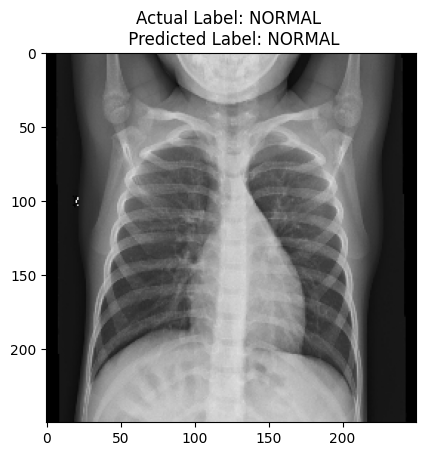

1/1 [==============================] - 0s 49ms/step


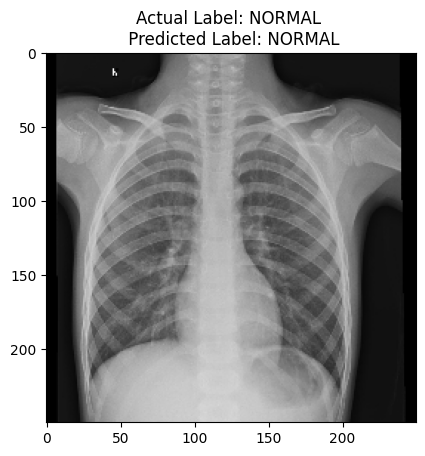

In [82]:
# General Classification
labels = ['COVID-19','NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']

def singlePred(batch, im):


    actual_label = labels[np.argmax(test_dataset.__getitem__(idx=batch)[1][im])]
    pred_label = labels[np.argmax(model.predict(test_dataset.__getitem__(idx=batch)[0])[im])]


    plt.imshow(test_dataset.__getitem__(idx=batch)[0][im])
    plt.title(f"Actual Label: {actual_label} \n Predicted Label: {pred_label}")
    plt.show()
    
for i in range(2):
    singlePred(12,i)

# LIME

In [62]:
import lime
from lime import lime_image


explainer = lime_image.LimeImageExplainer()

1/1 [==============================] - 0s 177ms/step


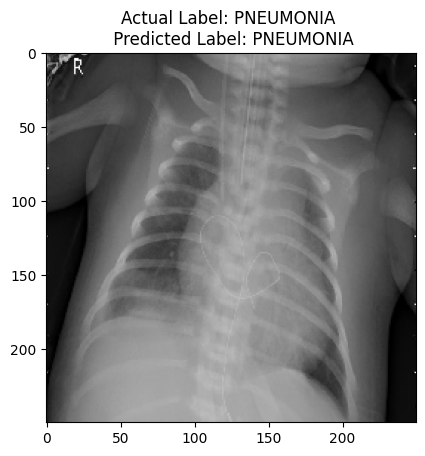

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 54ms/step


In [68]:
im = 5
batch = 24

singlePred(batch=batch, im=im)

explanation = explainer.explain_instance(test_dataset.__getitem__(idx=batch)[0][im].astype('double'), 
                                         model.predict, 
                                         top_labels=4,
                                         hide_color=0, 
                                         num_samples=1000)

In [65]:
from skimage.segmentation import mark_boundaries

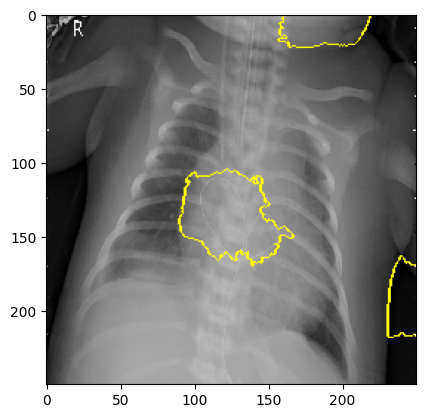

In [69]:
# only show region borders

temp, mask = explanation.get_image_and_mask(explanation.top_labels[2], 
                                            positive_only=True, 
                                            num_features=4, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

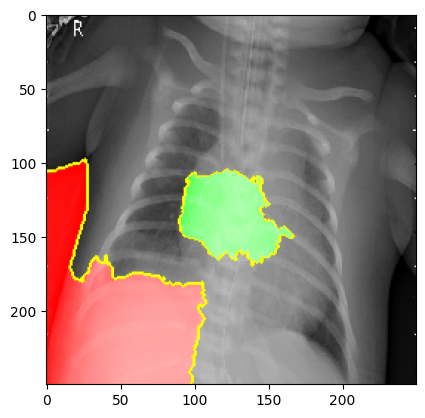

In [70]:
# Pros and Cons identified

temp, mask = explanation.get_image_and_mask(explanation.top_labels[2], 
                                            positive_only=False, 
                                            num_features=4, 
                                            hide_rest=False, 
                                            min_weight=0.01
                                            )
plt.imshow(mark_boundaries(temp, mask))

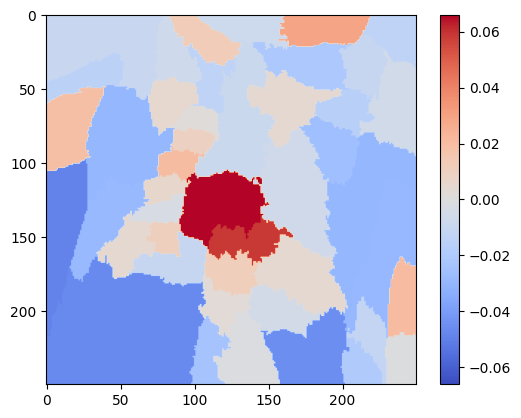

In [72]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[2]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'coolwarm', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()
plt.show()

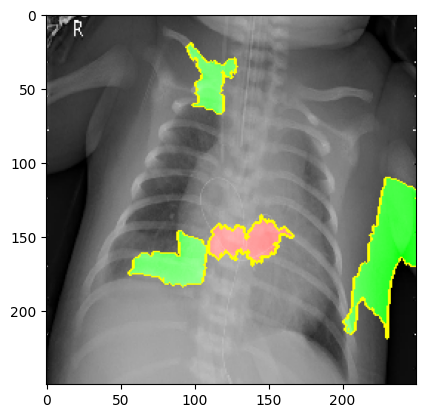

In [74]:
# Show wrong predictions regions

temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], 
                                            positive_only=False, 
                                            num_features=4, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

## All at once

1/1 [==============================] - 0s 173ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 87ms/step


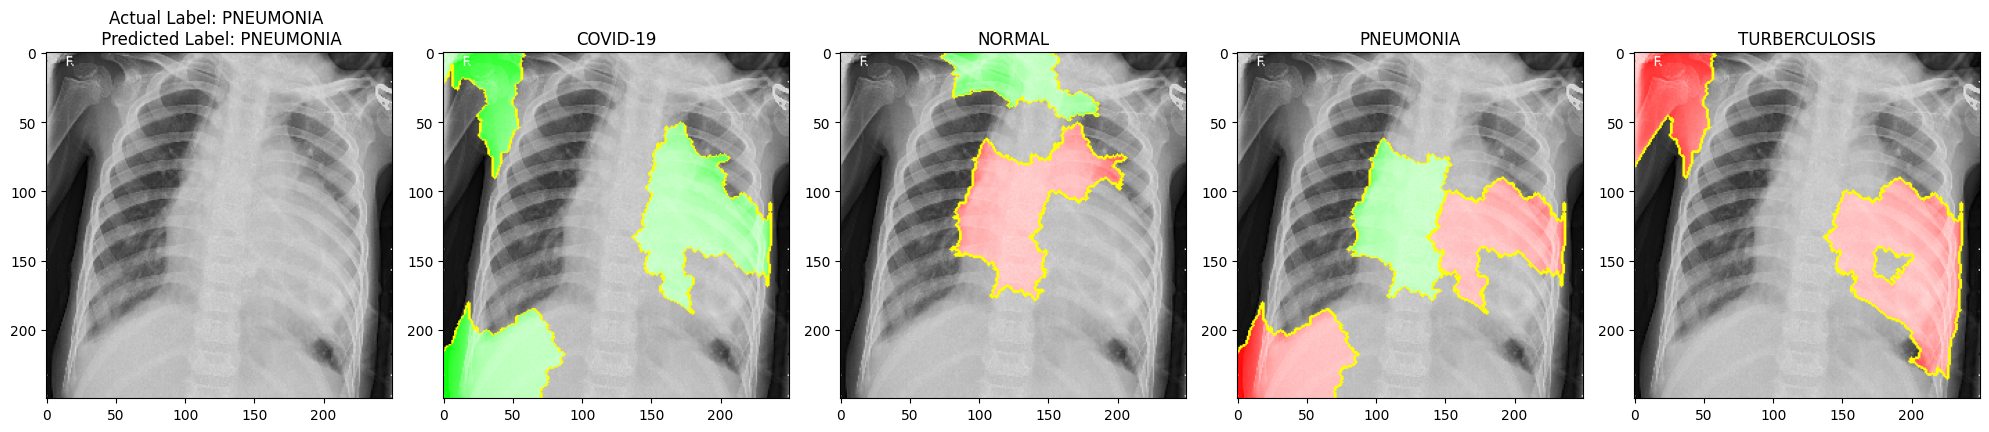

In [80]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))

batch = 22
im = 6

# -------------------------------------------

actual_label = labels[np.argmax(test_dataset.__getitem__(idx=batch)[1][im])]
pred_label = labels[np.argmax(model.predict(test_dataset.__getitem__(idx=batch)[0])[im])]

ax1.imshow(test_dataset.__getitem__(idx=batch)[0][im])
ax1.set_title(f"Actual Label: {actual_label} \n Predicted Label: {pred_label}")

# ------------------------------------------------


explanation = explainer.explain_instance(test_dataset.__getitem__(idx=batch)[0][im].astype('double'), 
                                         model.predict, 
                                         top_labels=4,
                                         hide_color=0, 
                                         num_samples=1000)

# ---------------------------------------------------


temp0, mask0 = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=False, 
                                            num_features=4, 
                                            hide_rest=False)
ax2.imshow(mark_boundaries(temp0, mask0))
ax2.set_title('COVID-19')

# ---------------------------------------------------

temp1, mask1 = explanation.get_image_and_mask(explanation.top_labels[1], 
                                            positive_only=False, 
                                            num_features=4, 
                                            hide_rest=False)

ax3.imshow(mark_boundaries(temp1, mask1))
ax3.set_title('NORMAL')

# ---------------------------------------------------

temp2, mask2 = explanation.get_image_and_mask(explanation.top_labels[2], 
                                            positive_only=False, 
                                            num_features=4, 
                                            hide_rest=False)


ax4.imshow(mark_boundaries(temp2, mask2))
ax4.set_title('PNEUMONIA')

# ---------------------------------------------------

temp3, mask3 = explanation.get_image_and_mask(explanation.top_labels[3], 
                                            positive_only=False, 
                                            num_features=4, 
                                            hide_rest=False)


ax5.imshow(mark_boundaries(temp3, mask3))
ax5.set_title('TURBERCULOSIS')

plt.tight_layout()
plt.show()